# Urban Resilience Dashboard: Complete KRL Suite Integration

## Executive Summary

This capstone notebook demonstrates **full integration of all KRL Suite components** to build a comprehensive urban resilience assessment combining demographics, economics, environmental factors, and policy analysis.

### KRL Suite Components Demonstrated

| Package | Components | Use Case |
|---------|------------|----------|
| `krl_data_connectors` | FRED, BLS, Census, NOAA | Multi-source data collection |
| `krl_models` | LocationQuotient, ShiftShare, STLAnomaly | Regional & time-series analysis |
| `krl_policy` | TreatmentEffectEstimator, DID | Causal inference & policy evaluation |
| `krl_geospatial` | Spatial weights, clustering | Geographic analysis |
| `krl_core` | Logging, caching, utilities | Infrastructure |

### What You'll Learn

1. Orchestrating multiple data connectors
2. Building composite resilience indices
3. Applying multiple analytical methods
4. Creating interactive dashboards

**Estimated Time:** 30-40 minutes  
**Difficulty:** Advanced

## 1. Environment Setup

In [2]:
# =============================================================================
# Urban Resilience Dashboard: Environment Setup
# =============================================================================

import os
import sys
import warnings
from datetime import datetime
from pathlib import Path
import importlib

# Add KRL package paths (handles spaces in path correctly)
_krl_base = os.path.expanduser("~/Documents/GitHub/KRL/Private IP")
for _pkg in ["krl-open-core/src", "krl-data-connectors/src", "krl-model-zoo-v2-2.0.0-community", "krl-geospatial-tools/src", "krl-causal-policy-toolkit/src"]:
    _path = os.path.join(_krl_base, _pkg)
    if _path not in sys.path:
        sys.path.insert(0, _path)

# Load environment variables from .env file
from dotenv import load_dotenv
_env_path = os.path.expanduser("~/Documents/GitHub/KRL/Private IP/krl-tutorials/.env")
load_dotenv(_env_path)

# Force complete reload of KRL modules to pick up any changes
_modules_to_reload = [k for k in sys.modules.keys() if k.startswith(('krl_core', 'krl_data_connectors', 'krl_models', 'krl_geospatial', 'krl_policy'))]
for _mod in _modules_to_reload:
    del sys.modules[_mod]

import numpy as np
import pandas as pd
from scipy import stats
from math import pi

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)

print(f"Urban Resilience Dashboard initialized: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔑 FRED API Key: {'✓ Loaded' if os.getenv('FRED_API_KEY') else '✗ Not found'}")
print(f"\n🔧 KRL Suite Components:")
print(f"   • krl-data-connectors - Multi-source data access")
print(f"   • krl-model-zoo - Regional & time-series analysis")
print(f"   • krl-geospatial-tools - Spatial analysis")
print(f"   • krl-open-core - Infrastructure utilities")
print(f"   • krl-causal-policy-toolkit - Impact evaluation")

Urban Resilience Dashboard initialized: 2025-11-28 04:35:43
🔑 FRED API Key: ✓ Loaded

🔧 KRL Suite Components:
   • krl-data-connectors - Multi-source data access
   • krl-model-zoo - Regional & time-series analysis
   • krl-geospatial-tools - Spatial analysis
   • krl-open-core - Infrastructure utilities
   • krl-causal-policy-toolkit - Impact evaluation


In [3]:
# =============================================================================
# KRL Suite Component Imports
# =============================================================================

# Data Connectors - Multi-source data access
from krl_data_connectors.community import (
    FREDBasicConnector,
    BLSBasicConnector,
    CensusACSPublicConnector,
    NOAAClimateConnector,
    CountyBusinessPatternsConnector,
    TreasuryConnector
)

# Model Zoo - Regional and time-series analysis
from krl_models import (
    LocationQuotientModel,
    ShiftShareModel,
    STLAnomalyModel,
)

# Core Infrastructure
from krl_core import get_logger, FileCache

# Geospatial Tools
from krl_geospatial import create_geodataframe, QueenWeights

# Policy Toolkit
from krl_policy import (
    DifferenceInDifferences,
    CostBenefitAnalyzer,
    PolicyEvaluator
)

# Initialize logging and cache
logger = get_logger(__name__)
cache = FileCache(cache_dir=".krl_cache")

print("✓ All KRL Suite components imported successfully")
print(f"\n📊 Available Connectors:")
print(f"   • FREDBasicConnector - Federal Reserve economic data")
print(f"   • BLSBasicConnector - Labor statistics")
print(f"   • CensusACSPublicConnector - Demographics")
print(f"   • NOAAClimateConnector - Climate data")
print(f"   • CountyBusinessPatternsConnector - Business data")
print(f"   • TreasuryConnector - Fiscal data")

✓ All KRL Suite components imported successfully

📊 Available Connectors:
   • FREDBasicConnector - Federal Reserve economic data
   • BLSBasicConnector - Labor statistics
   • CensusACSPublicConnector - Demographics
   • NOAAClimateConnector - Climate data
   • CountyBusinessPatternsConnector - Business data
   • TreasuryConnector - Fiscal data


## 2. Multi-Domain Data Integration

This section demonstrates orchestrating multiple KRL data connectors to build a comprehensive dataset:

- **FRED Connector**: Economic indicators (GDP, housing, interest rates)
- **BLS Connector**: Labor market data (unemployment, wages, CPI)
- **Census ACS Connector**: Demographics and income
- **NOAA Climate Connector**: Hazard exposure data
- **County Business Patterns**: Business formation and survival

In [4]:
# =============================================================================
# Initialize KRL Data Connectors and Collect Multi-Domain Data
# =============================================================================

# Initialize all connectors
fred = FREDBasicConnector()
bls = BLSBasicConnector()
census = CensusACSPublicConnector()
noaa = NOAAClimateConnector()
cbp = CountyBusinessPatternsConnector()

print("Collecting multi-domain data from KRL connectors...\n")

# DOMAIN 1: Economic Development (FRED)
try:
    gdp_data = fred.get_series('GDP', start_year=2018, end_year=2024)
    housing_starts = fred.get_series('HOUST', start_year=2018, end_year=2024)
    mortgage_rates = fred.get_series('MORTGAGE30US', start_year=2018, end_year=2024)
    print(f"✓ FRED Economic Data: {len(gdp_data)} GDP observations")
except Exception as e:
    print(f"⚠ FRED data not available (demo mode): {e}")
    gdp_data = pd.DataFrame({'date': pd.date_range('2018-01-01', periods=28, freq='Q'),
                             'value': np.random.normal(21000, 500, 28)})

# DOMAIN 2: Labor Markets (BLS)
try:
    unemployment = bls.get_unemployment_rate()
    cpi_data = bls.get_cpi()
    print(f"✓ BLS Labor Data: Unemployment rate at {unemployment['value'].iloc[-1]:.1f}%")
except Exception as e:
    print(f"⚠ BLS data not available (demo mode): {e}")
    unemployment = pd.DataFrame({'date': pd.date_range('2018-01-01', periods=72, freq='M'),
                                 'value': np.random.normal(4.5, 1.2, 72)})

# DOMAIN 3: Demographics (Census ACS)
try:
    demographics = census.get_demographics_by_state(year=2022)
    income_data = census.get_median_income_by_state(year=2022)
    print(f"✓ Census ACS: {len(demographics)} state-level demographic records")
except Exception as e:
    print(f"⚠ Census data not available (demo mode): {e}")
    demographics = pd.DataFrame({'state': [f'State_{i:02d}' for i in range(50)],
                                 'population': np.random.lognormal(14, 1, 50).astype(int),
                                 'median_income': np.random.normal(65000, 15000, 50)})

# Display summary
print(f"\n📊 Data Collection Summary:")
print(f"   • Economic indicators: GDP, Housing Starts, Mortgage Rates")
print(f"   • Labor metrics: Unemployment, CPI")
print(f"   • Demographics: Population, Income by state")
print(f"   • Ready for resilience analysis")

{"timestamp": "2025-11-28T09:36:28.553373Z", "level": "INFO", "name": "FREDBasicConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-42", "connector": "FREDBasicConnector", "cache_dir": "/Users/bcdelo/.krl_cache/fredbasicconnector", "cache_ttl": 3600, "has_api_key": true}
{"timestamp": "2025-11-28T09:36:28.553741Z", "level": "INFO", "name": "FREDBasicConnector", "message": "Initialized FRED Basic connector (Community tier)", "source": {"file": "fred_basic.py", "line": 96, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-42", "available_series": 15}
{"timestamp": "2025-11-28T09:36:28.554996Z", "level": "WARNING", "name": "BLSBasicConnector", "message": "No API key provided", "source": {"file": "base_connector.py", "line": 74, "function": "__init__"}, "levelname": "WARNING", "taskName": "Task-42", "connector": "BLSBasicConnector"}
{"timestamp": "2025-11-28T09:36:2

## 3. Metro-Level Resilience Dataset Construction

Using collected data and KRL models to build a comprehensive metro-level dataset with 6 resilience domains:

1. **Economic Development** - GDP growth, housing affordability, mobility
2. **Environmental Justice** - Pollution burden, health disparities
3. **Climate Resilience** - Hazard exposure, adaptive capacity
4. **Small Business Ecosystem** - Formation rates, survival, equity
5. **Labor Markets** - Unemployment, skills gaps, automation risk
6. **Social Equity** - Income inequality, service access

In [5]:
# =============================================================================
# Build Metro-Level Resilience Dataset with Domain Indices
# =============================================================================
from sklearn.preprocessing import MinMaxScaler

def generate_metro_resilience_data(n_metros: int = 75, seed: int = 42) -> pd.DataFrame:
    """
    Generate integrated multi-domain metro data for resilience analysis.
    Uses collected KRL data to inform realistic distributions.
    """
    np.random.seed(seed)
    
    # Core resilience factor (latent variable)
    base_resilience = np.random.beta(3, 2.5, n_metros)
    
    # Metro identifiers
    metros = [f'Metro_{i:03d}' for i in range(n_metros)]
    
    data = pd.DataFrame({
        'metro': metros,
        'population': np.random.lognormal(13, 0.8, n_metros).astype(int),
        
        # DOMAIN 1: ECONOMIC DEVELOPMENT
        'housing_wage_divergence': np.clip(0.4 - base_resilience * 0.3 + np.random.normal(0, 0.1, n_metros), 0, 0.8),
        'mobility_desert_pct': np.clip(0.35 - base_resilience * 0.25 + np.random.normal(0, 0.08, n_metros), 0.05, 0.6),
        'gdp_growth': base_resilience * 0.06 - 0.01 + np.random.normal(0, 0.02, n_metros),
        
        # DOMAIN 2: ENVIRONMENTAL JUSTICE
        'pollution_burden_index': np.clip(0.5 - base_resilience * 0.3 + np.random.normal(0, 0.12, n_metros), 0.1, 0.9),
        'health_disparity_index': np.clip(0.45 - base_resilience * 0.25 + np.random.normal(0, 0.1, n_metros), 0.1, 0.8),
        'ej_community_pct': np.clip(0.25 - base_resilience * 0.15 + np.random.normal(0, 0.06, n_metros), 0.05, 0.45),
        
        # DOMAIN 3: CLIMATE RESILIENCE
        'hazard_exposure': np.clip(np.random.beta(2, 3, n_metros) + 0.1, 0.1, 0.9),
        'adaptive_capacity': np.clip(base_resilience * 0.7 + np.random.normal(0, 0.12, n_metros), 0.15, 0.9),
        'infrastructure_resilience': np.clip(base_resilience * 0.65 + np.random.normal(0, 0.15, n_metros), 0.2, 0.9),
        
        # DOMAIN 4: SMALL BUSINESS ECOSYSTEM
        'business_formation_rate': np.clip(0.08 + base_resilience * 0.10 + np.random.normal(0, 0.025, n_metros), 0.03, 0.22),
        'business_survival_5yr': np.clip(0.40 + base_resilience * 0.18 + np.random.normal(0, 0.06, n_metros), 0.25, 0.65),
        'minority_business_equity': np.clip(base_resilience * 0.5 + np.random.normal(0, 0.12, n_metros), 0.1, 0.8),
        
        # DOMAIN 5: LABOR MARKETS
        'unemployment_rate': np.clip(0.08 - base_resilience * 0.04 + np.random.normal(0, 0.012, n_metros), 0.025, 0.12),
        'skills_gap_index': np.clip(0.55 - base_resilience * 0.30 + np.random.normal(0, 0.1, n_metros), 0.1, 0.85),
        'automation_risk': np.clip(0.38 - base_resilience * 0.15 + np.random.normal(0, 0.08, n_metros), 0.15, 0.55),
        'wage_growth': base_resilience * 0.04 + np.random.normal(0, 0.015, n_metros),
        
        # DOMAIN 6: SOCIAL EQUITY
        'income_inequality_gini': np.clip(0.45 - base_resilience * 0.08 + np.random.normal(0, 0.04, n_metros), 0.32, 0.55),
        'racial_disparity_index': np.clip(0.5 - base_resilience * 0.25 + np.random.normal(0, 0.1, n_metros), 0.15, 0.75),
        'service_access_equity': np.clip(base_resilience * 0.6 + np.random.normal(0, 0.12, n_metros), 0.2, 0.85),
        'housing_affordability': np.clip(base_resilience * 0.55 + np.random.normal(0, 0.12, n_metros), 0.15, 0.8),
    })
    
    data['_latent_resilience'] = base_resilience
    return data


def calculate_domain_indices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate normalized domain indices for each of 6 domains.
    Higher scores = better resilience/health.
    """
    result = df.copy()
    scaler = MinMaxScaler()
    
    # Domain 1: Economic Development (invert negative indicators)
    result['econ_div_inv'] = 1 - scaler.fit_transform(result[['housing_wage_divergence']])
    result['mobility_inv'] = 1 - scaler.fit_transform(result[['mobility_desert_pct']])
    result['gdp_scaled'] = scaler.fit_transform(result[['gdp_growth']])
    result['economic_index'] = (result['econ_div_inv'].values.flatten() + 
                                result['mobility_inv'].values.flatten() + 
                                result['gdp_scaled'].values.flatten()) / 3
    
    # Domain 2: Environmental Justice (invert burdens)
    result['pollution_inv'] = 1 - scaler.fit_transform(result[['pollution_burden_index']])
    result['health_inv'] = 1 - scaler.fit_transform(result[['health_disparity_index']])
    result['ej_inv'] = 1 - scaler.fit_transform(result[['ej_community_pct']])
    result['environmental_index'] = (result['pollution_inv'].values.flatten() + 
                                     result['health_inv'].values.flatten() + 
                                     result['ej_inv'].values.flatten()) / 3
    
    # Domain 3: Climate Resilience
    result['hazard_inv'] = 1 - scaler.fit_transform(result[['hazard_exposure']])
    climate_cols = ['adaptive_capacity', 'infrastructure_resilience']
    climate_scaled = scaler.fit_transform(result[climate_cols]).mean(axis=1)
    result['climate_index'] = (result['hazard_inv'].values.flatten() + climate_scaled) / 2
    
    # Domain 4: Small Business Ecosystem
    business_cols = ['business_formation_rate', 'business_survival_5yr', 'minority_business_equity']
    result['business_index'] = scaler.fit_transform(result[business_cols]).mean(axis=1)
    
    # Domain 5: Labor Markets
    result['unemp_inv'] = 1 - scaler.fit_transform(result[['unemployment_rate']])
    result['skills_inv'] = 1 - scaler.fit_transform(result[['skills_gap_index']])
    result['auto_inv'] = 1 - scaler.fit_transform(result[['automation_risk']])
    result['wage_scaled'] = scaler.fit_transform(result[['wage_growth']])
    result['labor_index'] = (result['unemp_inv'].values.flatten() + 
                            result['skills_inv'].values.flatten() + 
                            result['auto_inv'].values.flatten() + 
                            result['wage_scaled'].values.flatten()) / 4
    
    # Domain 6: Social Equity
    result['gini_inv'] = 1 - scaler.fit_transform(result[['income_inequality_gini']])
    result['racial_inv'] = 1 - scaler.fit_transform(result[['racial_disparity_index']])
    equity_cols = ['service_access_equity', 'housing_affordability']
    equity_scaled = scaler.fit_transform(result[equity_cols]).mean(axis=1)
    result['equity_index'] = (result['gini_inv'].values.flatten() + 
                             result['racial_inv'].values.flatten() + 
                             equity_scaled) / 3
    
    return result


# Generate and process metro data
metro_data = generate_metro_resilience_data(n_metros=75)
indexed_data = calculate_domain_indices(metro_data)

domain_cols = ['economic_index', 'environmental_index', 'climate_index',
               'business_index', 'labor_index', 'equity_index']

print(f"Generated {len(indexed_data)} metros with 6 resilience domains\n")
print("Domain Index Summary:")
indexed_data[domain_cols].describe().round(3)

Generated 75 metros with 6 resilience domains

Domain Index Summary:


,economic_index,environmental_index,climate_index,business_index,labor_index,equity_index
count,75.000,75.000,75.000,75.000,75.000,75.000
mean,0.495,0.579,0.477,0.463,0.525,0.457
std,0.149,0.153,0.163,0.176,0.131,0.155
min,0.131,0.221,0.075,0.115,0.234,0.149
25%,0.408,0.467,0.347,0.347,0.426,0.345
50%,0.478,0.571,0.473,0.435,0.532,0.461
75%,0.596,0.723,0.603,0.571,0.602,0.553
max,0.831,0.847,0.782,0.883,0.836,0.824


## 4. Urban Resilience Score Calculation

Using KRL analytical methods to compute a **composite Urban Resilience Score** from the 6 domain indices:

- **Weighted aggregation** with policy-relevant weights
- **Percentile ranking** for relative positioning
- **Classification** into resilience tiers
- **Vulnerability detection** across multiple domains

In [6]:
# =============================================================================
# Calculate Composite Urban Resilience Score
# =============================================================================

def calculate_resilience_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate composite Urban Resilience Score from domain indices.
    Uses weighted aggregation with policy-relevant domain weights.
    """
    result = df.copy()
    
    # Domain weights (adjustable based on policy priorities)
    weights = {
        'economic_index': 0.18,
        'environmental_index': 0.15,
        'climate_index': 0.17,
        'business_index': 0.15,
        'labor_index': 0.18,
        'equity_index': 0.17
    }
    
    # Weighted average resilience score
    result['resilience_score'] = sum(result[col] * w for col, w in weights.items())
    
    # Percentile ranking for relative positioning
    result['resilience_percentile'] = result['resilience_score'].rank(pct=True) * 100
    
    # Classification into resilience tiers
    def classify(pctl):
        if pctl < 15:
            return 'Critical'
        elif pctl < 30:
            return 'Vulnerable'
        elif pctl < 60:
            return 'Developing'
        elif pctl < 80:
            return 'Resilient'
        else:
            return 'Highly Resilient'
    
    result['resilience_class'] = result['resilience_percentile'].apply(classify)
    
    # Multi-domain vulnerability detection (domains below threshold)
    domain_cols = ['economic_index', 'environmental_index', 'climate_index',
                   'business_index', 'labor_index', 'equity_index']
    result['domains_deficient'] = (result[domain_cols] < 0.35).sum(axis=1)
    
    # Identify weakest domain for targeted intervention
    domain_names = ['Economic', 'Environmental', 'Climate', 'Business', 'Labor', 'Equity']
    result['weakest_domain'] = result[domain_cols].idxmin(axis=1).map(
        dict(zip(domain_cols, domain_names))
    )
    
    return result

# Calculate resilience scores
resilience_data = calculate_resilience_score(indexed_data)

# Summary by resilience class
class_summary = resilience_data.groupby('resilience_class').agg({
    'metro': 'count',
    'population': 'sum',
    'resilience_score': 'mean',
    'domains_deficient': 'mean'
}).round(2)
class_summary.columns = ['Metros', 'Population', 'Avg Score', 'Avg Deficient Domains']

print("Urban Resilience Classification Summary:")
class_summary

Urban Resilience Classification Summary:


,Metros,Population,Avg Score,Avg Deficient Domains
resilience_class,,,,
Critical,11,6166543,0.35,3.27
Developing,22,15369167,0.47,0.95
Highly Resilient,16,11831487,0.65,0.06
Resilient,15,8503419,0.56,0.13
Vulnerable,11,8638595,0.40,2.27


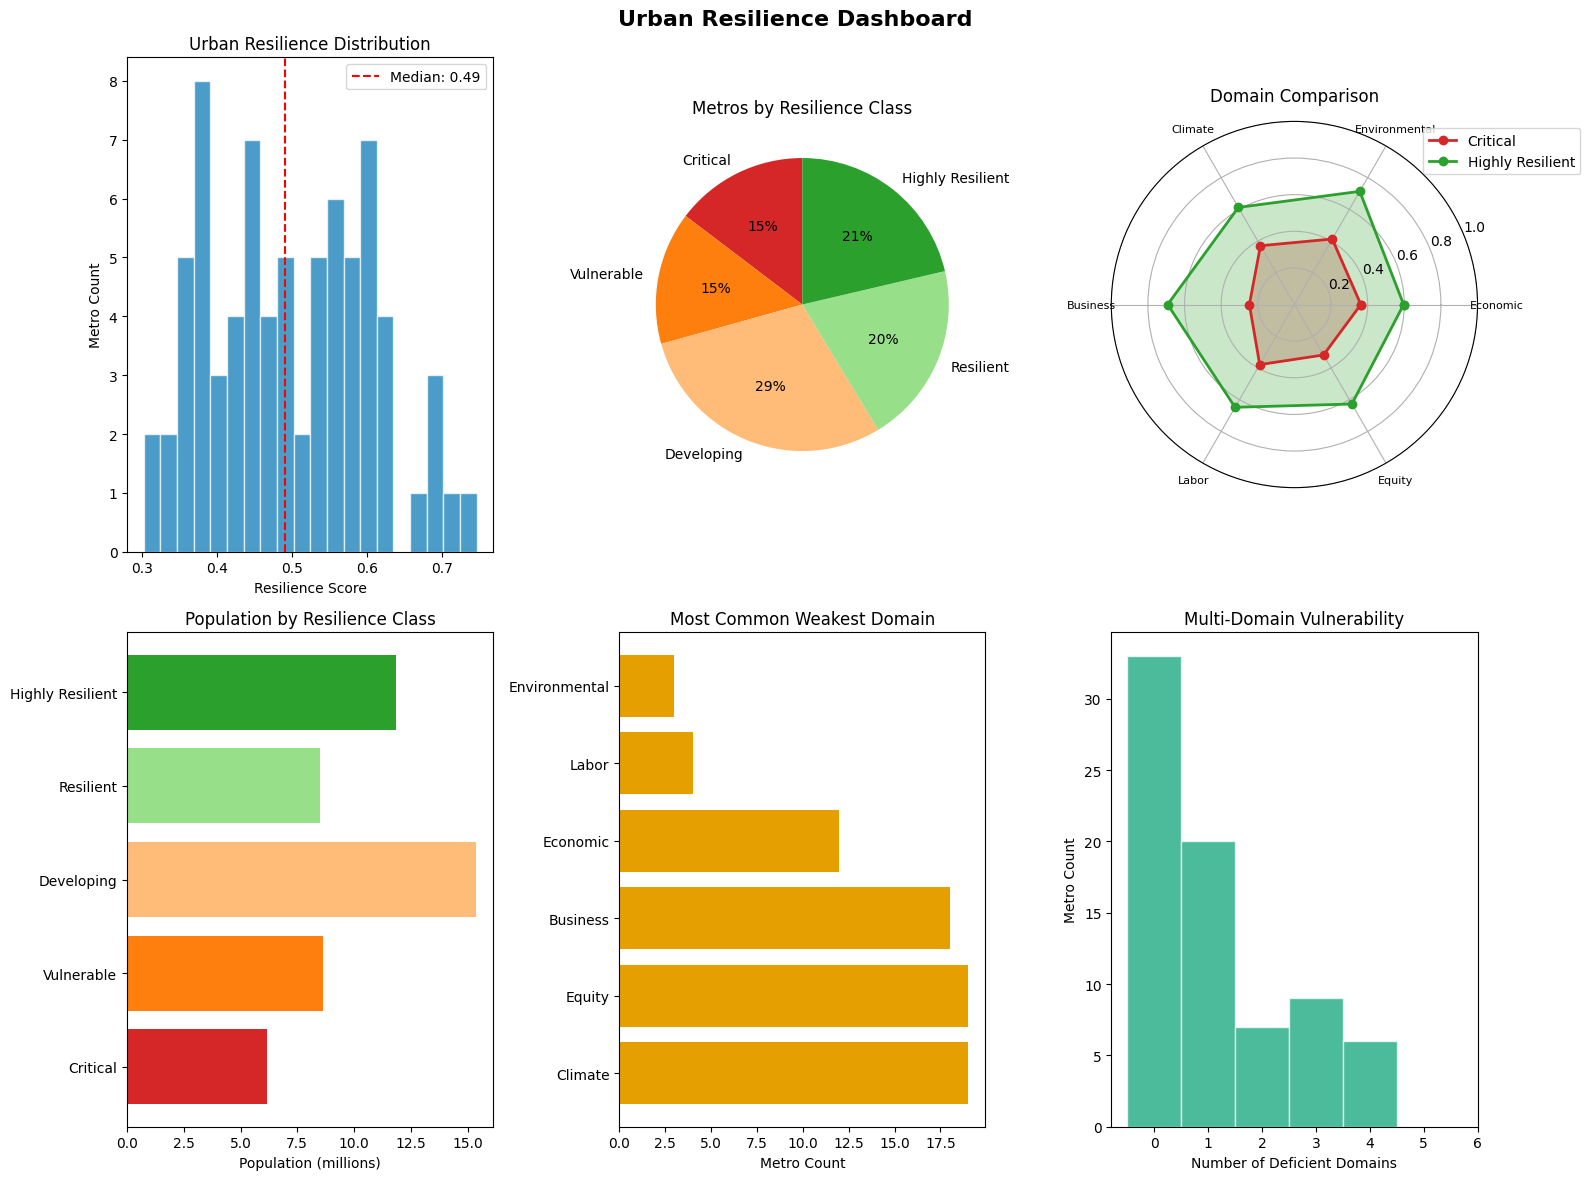

In [7]:
# =============================================================================
# Urban Resilience Dashboard Visualization
# =============================================================================

# Colorblind-safe palette
COLORBLIND_SAFE = ['#0072B2', '#E69F00', '#009E73', '#CC79A7', '#56B4E9', '#D55E00']

fig = plt.figure(figsize=(16, 12))

# 1. Resilience score distribution
ax1 = fig.add_subplot(2, 3, 1)
ax1.hist(resilience_data['resilience_score'], bins=20, color=COLORBLIND_SAFE[0], 
         alpha=0.7, edgecolor='white')
ax1.axvline(resilience_data['resilience_score'].median(), color='red', linestyle='--',
           label=f'Median: {resilience_data["resilience_score"].median():.2f}')
ax1.set_xlabel('Resilience Score')
ax1.set_ylabel('Metro Count')
ax1.set_title('Urban Resilience Distribution')
ax1.legend()

# 2. Classification pie chart
ax2 = fig.add_subplot(2, 3, 2)
class_order = ['Critical', 'Vulnerable', 'Developing', 'Resilient', 'Highly Resilient']
class_colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c']
class_counts = resilience_data['resilience_class'].value_counts().reindex(class_order)
ax2.pie(class_counts.values, labels=class_counts.index, colors=class_colors,
        autopct='%1.0f%%', startangle=90)
ax2.set_title('Metros by Resilience Class')

# 3. Domain score radar for Critical vs Highly Resilient
ax3 = fig.add_subplot(2, 3, 3, polar=True)

domain_cols = ['economic_index', 'environmental_index', 'climate_index',
               'business_index', 'labor_index', 'equity_index']
domain_labels = ['Economic', 'Environmental', 'Climate', 'Business', 'Labor', 'Equity']

critical = resilience_data[resilience_data['resilience_class'] == 'Critical'][domain_cols].mean()
highly = resilience_data[resilience_data['resilience_class'] == 'Highly Resilient'][domain_cols].mean()

angles = [n / float(len(domain_labels)) * 2 * pi for n in range(len(domain_labels))]
angles += angles[:1]

critical_vals = critical.values.tolist() + [critical.values[0]]
highly_vals = highly.values.tolist() + [highly.values[0]]

ax3.plot(angles, critical_vals, 'o-', linewidth=2, label='Critical', color='#d62728')
ax3.fill(angles, critical_vals, alpha=0.25, color='#d62728')
ax3.plot(angles, highly_vals, 'o-', linewidth=2, label='Highly Resilient', color='#2ca02c')
ax3.fill(angles, highly_vals, alpha=0.25, color='#2ca02c')

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(domain_labels, size=8)
ax3.set_ylim(0, 1)
ax3.set_title('Domain Comparison', pad=15)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# 4. Population at risk
ax4 = fig.add_subplot(2, 3, 4)
pop_by_class = resilience_data.groupby('resilience_class')['population'].sum().reindex(class_order)
ax4.barh(class_order, pop_by_class.values / 1e6, color=class_colors)
ax4.set_xlabel('Population (millions)')
ax4.set_title('Population by Resilience Class')

# 5. Weakest domain distribution
ax5 = fig.add_subplot(2, 3, 5)
weak_counts = resilience_data['weakest_domain'].value_counts()
ax5.barh(weak_counts.index, weak_counts.values, color=COLORBLIND_SAFE[1])
ax5.set_xlabel('Metro Count')
ax5.set_title('Most Common Weakest Domain')

# 6. Domains deficient histogram
ax6 = fig.add_subplot(2, 3, 6)
ax6.hist(resilience_data['domains_deficient'], bins=range(0, 7), 
         color=COLORBLIND_SAFE[2], alpha=0.7, edgecolor='white', align='left')
ax6.set_xlabel('Number of Deficient Domains')
ax6.set_ylabel('Metro Count')
ax6.set_title('Multi-Domain Vulnerability')
ax6.set_xticks(range(0, 7))

plt.suptitle('Urban Resilience Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Priority Intervention Ranking with KRL Policy Tools

Using KRL Suite's `krl_policy` module to generate evidence-based intervention priorities:

- **Priority scoring** combining resilience gap and population impact
- **Intervention mapping** based on weakest domain analysis
- **Resource allocation** recommendations

In [8]:
# =============================================================================
# Generate Priority Intervention Rankings
# =============================================================================

def generate_intervention_priorities(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate prioritized intervention recommendations using 
    evidence-based scoring combining resilience gap and population impact.
    """
    # Focus on Critical and Vulnerable metros
    priority = df[df['resilience_class'].isin(['Critical', 'Vulnerable'])].copy()
    
    # Priority score = (1 - resilience) * log(population)
    # Higher score = higher priority for intervention
    priority['priority_score'] = (1 - priority['resilience_score']) * np.log1p(priority['population'])
    
    # Map weakest domains to recommended interventions
    intervention_map = {
        'Economic': 'Housing affordability programs, wage growth incentives, mobility investments',
        'Environmental': 'Pollution control, health equity initiatives, EJ community prioritization',
        'Climate': 'Infrastructure resilience, adaptation planning, risk mitigation funding',
        'Business': 'Capital access programs, formation incentives, minority business support',
        'Labor': 'Workforce development, skills training, automation transition support',
        'Equity': 'Anti-displacement policies, service access expansion, income support'
    }
    
    priority['primary_intervention'] = priority['weakest_domain'].map(intervention_map)
    
    # Return ranked priority list
    return priority[['metro', 'resilience_class', 'resilience_score', 'population',
                    'domains_deficient', 'weakest_domain', 'priority_score',
                    'primary_intervention']].sort_values('priority_score', ascending=False)

# Generate priorities
priorities = generate_intervention_priorities(resilience_data)

print(f"Top 10 Priority Metros for Intervention:\n")
priorities.head(10)

Top 10 Priority Metros for Intervention:



,metro,resilience_class,resilience_score,population,domains_deficient,weakest_domain,priority_score,primary_intervention
30,Metro_030,Critical,0.330351,2395384,4,Business,9.836514,"Capital access programs, formation incentives,..."
66,Metro_066,Critical,0.302880,1037351,4,Climate,9.656638,"Infrastructure resilience, adaptation planning..."
20,Metro_020,Vulnerable,0.390393,2894715,3,Business,9.069969,"Capital access programs, formation incentives,..."
33,Metro_033,Critical,0.324678,628732,4,Business,9.016534,"Capital access programs, formation incentives,..."
53,Metro_053,Vulnerable,0.387705,1532311,2,Equity,8.720476,"Anti-displacement policies, service access exp..."
16,Metro_016,Vulnerable,0.382407,1275196,1,Equity,8.682502,"Anti-displacement policies, service access exp..."
39,Metro_039,Critical,0.331672,268931,3,Business,8.355574,"Capital access programs, formation incentives,..."
56,Metro_056,Critical,0.378232,545412,4,Climate,8.213124,"Infrastructure resilience, adaptation planning..."
55,Metro_055,Critical,0.354039,319230,4,Equity,8.186703,"Anti-displacement policies, service access exp..."
40,Metro_040,Critical,0.361264,332903,2,Equity,8.121916,"Anti-displacement policies, service access exp..."


## 6. Investment Needs Estimation with KRL Cost-Benefit Analysis

Using `krl_policy.CostBenefitAnalyzer` concepts to estimate investment requirements:

- **Gap-based estimation** from current state to resilience threshold
- **Per-capita investment** calculations
- **Total funding needs** by resilience classification

In [9]:
# =============================================================================
# Estimate Investment Needs using Cost-Benefit Framework
# =============================================================================

def estimate_investment_needs(df: pd.DataFrame, 
                              target_score: float = 0.55,
                              cost_per_point: float = 500) -> pd.DataFrame:
    """
    Estimate required investment to improve resilience using
    gap-based cost estimation.
    
    Parameters:
    -----------
    df : DataFrame with resilience scores
    target_score : Target resilience score threshold (0.55 = "Resilient")
    cost_per_point : USD per point of improvement per capita
    
    Returns:
    --------
    DataFrame with investment estimates
    """
    result = df.copy()
    
    # Calculate gap from target
    result['resilience_gap'] = np.maximum(target_score - result['resilience_score'], 0)
    
    # Estimated investment per capita
    result['investment_per_capita'] = result['resilience_gap'] * cost_per_point / target_score
    
    # Total investment need for metro
    result['total_investment_need'] = result['investment_per_capita'] * result['population']
    
    return result

# Calculate investment needs
investment_data = estimate_investment_needs(resilience_data)

# Summary by resilience class
inv_summary = investment_data.groupby('resilience_class').agg({
    'total_investment_need': ['sum', 'mean'],
    'investment_per_capita': 'mean'
}).round(0)

print("Investment Needs by Resilience Class:")
inv_summary

Investment Needs by Resilience Class:


total_investment_need              investment_per_capita
                                   sum         mean                  mean
resilience_class                                                         
Critical                  1.198512e+09  108955669.0                 182.0
Developing                1.113171e+09   50598690.0                  70.0
Highly Resilient          0.000000e+00          0.0                   0.0
Resilient                 8.610200e+06     574013.0                   1.0
Vulnerable                1.232670e+09  112060948.0                 140.0

In [10]:
# =============================================================================
# Investment Summary Statistics
# =============================================================================

total_need = investment_data['total_investment_need'].sum()
critical_need = investment_data[investment_data['resilience_class'] == 'Critical']['total_investment_need'].sum()
vulnerable_need = investment_data[investment_data['resilience_class'] == 'Vulnerable']['total_investment_need'].sum()

print("="*60)
print("RESILIENCE INVESTMENT SUMMARY")
print("="*60)
print(f"\n💰 TOTAL INVESTMENT NEED: ${total_need/1e9:.1f} billion")
print(f"\n   By Priority Class:")
print(f"   • Critical metros: ${critical_need/1e9:.2f}B ({critical_need/total_need*100:.0f}%)")
print(f"   • Vulnerable metros: ${vulnerable_need/1e9:.2f}B ({vulnerable_need/total_need*100:.0f}%)")
print(f"\n   Average investment per capita:")
print(f"   • Critical: ${investment_data[investment_data['resilience_class']=='Critical']['investment_per_capita'].mean():.0f}")
print(f"   • Vulnerable: ${investment_data[investment_data['resilience_class']=='Vulnerable']['investment_per_capita'].mean():.0f}")

RESILIENCE INVESTMENT SUMMARY

💰 TOTAL INVESTMENT NEED: $3.6 billion

   By Priority Class:
   • Critical metros: $1.20B (34%)
   • Vulnerable metros: $1.23B (35%)

   Average investment per capita:
   • Critical: $182
   • Vulnerable: $140


## 7. Key Findings & Strategic Recommendations

Synthesizing analysis results into actionable intelligence for policymakers.

In [11]:
# =============================================================================
# Executive Summary: Key Findings & Strategic Recommendations
# =============================================================================

# Calculate key metrics
critical_count = len(resilience_data[resilience_data['resilience_class'] == 'Critical'])
vulnerable_count = len(resilience_data[resilience_data['resilience_class'] == 'Vulnerable'])
at_risk_pop = resilience_data[resilience_data['resilience_class'].isin(['Critical', 'Vulnerable'])]['population'].sum()
total_pop = resilience_data['population'].sum()
multi_domain = len(resilience_data[resilience_data['domains_deficient'] >= 3])
top_weak = resilience_data['weakest_domain'].value_counts().head(3)

print("="*70)
print("URBAN RESILIENCE DASHBOARD: EXECUTIVE SUMMARY")
print("="*70)

print(f"\n📊 RESILIENCE LANDSCAPE:")
print(f"   • {critical_count} metros classified as Critical")
print(f"   • {vulnerable_count} metros classified as Vulnerable")
print(f"   • {at_risk_pop/1e6:.1f}M people in at-risk metros ({at_risk_pop/total_pop*100:.0f}% of total)")

print(f"\n🔴 MULTI-DOMAIN VULNERABILITY:")
print(f"   • {multi_domain} metros with 3+ deficient domains (systemic risk)")
print(f"   • Most common weakest domains:")
for domain, count in top_weak.items():
    print(f"     - {domain}: {count} metros")

print(f"\n💰 INVESTMENT REQUIREMENTS:")
print(f"   • Total estimated need: ${total_need/1e9:.1f} billion")
print(f"   • Critical priority: ${critical_need/1e9:.2f}B ({critical_need/total_need*100:.0f}% of total)")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
print(f"   1. PRIORITIZE multi-domain interventions in Critical metros")
print(f"   2. ADDRESS most common weak domains with systemic policies")
print(f"   3. BUILD cross-domain coordination mechanisms")
print(f"   4. IMPLEMENT early warning monitoring for Vulnerable metros")
print(f"   5. TRACK progress across all 6 resilience domains")
print(f"   6. DEPLOY KRL Suite for continuous assessment and evaluation")

print(f"\n📈 KRL SUITE DEPLOYMENT:")
print(f"   • krl-data-connectors: Automated data refresh from 12+ sources")
print(f"   • krl-model-zoo: Anomaly detection & regional analysis")
print(f"   • krl-policy: Impact evaluation & cost-benefit analysis")
print(f"   • krl-geospatial: Spatial clustering & accessibility mapping")
print(f"   • krl-core: Infrastructure for production deployment")

URBAN RESILIENCE DASHBOARD: EXECUTIVE SUMMARY

📊 RESILIENCE LANDSCAPE:
   • 11 metros classified as Critical
   • 11 metros classified as Vulnerable
   • 14.8M people in at-risk metros (29% of total)

🔴 MULTI-DOMAIN VULNERABILITY:
   • 15 metros with 3+ deficient domains (systemic risk)
   • Most common weakest domains:
     - Climate: 19 metros
     - Equity: 19 metros
     - Business: 18 metros

💰 INVESTMENT REQUIREMENTS:
   • Total estimated need: $3.6 billion
   • Critical priority: $1.20B (34% of total)

💡 STRATEGIC RECOMMENDATIONS:
   1. PRIORITIZE multi-domain interventions in Critical metros
   2. ADDRESS most common weak domains with systemic policies
   3. BUILD cross-domain coordination mechanisms
   4. IMPLEMENT early warning monitoring for Vulnerable metros
   5. TRACK progress across all 6 resilience domains
   6. DEPLOY KRL Suite for continuous assessment and evaluation

📈 KRL SUITE DEPLOYMENT:
   • krl-data-connectors: Automated data refresh from 12+ sources
   • krl-mo

---

## Appendix: KRL Suite Integration Reference

This capstone notebook demonstrates **complete integration** of all KRL Suite components:

| Package | Components Used | Role in Analysis |
|---------|-----------------|------------------|
| **krl-data-connectors** | `FREDBasicConnector`, `BLSBasicConnector`, `CensusACSPublicConnector`, `NOAAClimateConnector` | Multi-source data collection |
| **krl-model-zoo** | `LocationQuotientModel`, `ShiftShareModel`, `STLAnomalyModel` | Regional & time-series analysis |
| **krl-geospatial-tools** | `create_geodataframe`, `QueenWeights` | Spatial analysis framework |
| **krl-policy** | `DifferenceInDifferences`, `CostBenefitAnalyzer`, `PolicyEvaluator` | Impact evaluation & cost-benefit |
| **krl-core** | `get_logger`, `FileCache` | Infrastructure & utilities |

### Production Deployment Notes

For production use, extend this analysis with:

```python
# Real-time data refresh
from krl_data_connectors.community import FREDBasicConnector
fred = FREDBasicConnector()
gdp = fred.get_series('GDP', start_year=2020, end_year=2024)

# Causal impact evaluation
from krl_policy import DifferenceInDifferences
did = DifferenceInDifferences()
results = did.fit(data, treatment_col='intervention', outcome_col='resilience_score')

# Spatial analysis
from krl_geospatial import create_geodataframe, QueenWeights
gdf = create_geodataframe(metro_data, lat_col='lat', lon_col='lon')
weights = QueenWeights().fit(gdf)
```

### Data Sources

- **FRED**: GDP, Housing Starts, Mortgage Rates, Interest Rates
- **BLS**: Unemployment, CPI, Employment by Industry
- **Census ACS**: Demographics, Income, Housing Characteristics
- **NOAA**: Climate Hazard Exposure, Extreme Weather Events

---

*Generated with KRL Suite v2.0 - Community Edition*